# Structured Outputs with LLMs and its applications

In [ ]:
!pip install -r requirements.txt

To work with this notebook, please create a file called `api_keys` and define two variables there:

```bash
NEBIUS_API_KEY="<YOUR_API_KEY>"
OPENAI_API_KEY="<YOUR_API_KEY>"
```

In [1]:
from dotenv import load_dotenv

print(f".env file is loaded: {load_dotenv()}")

.env file is loaded: True


### Let's wrap some functions that will ease our futher work with the `completions` API

In [2]:
import os
import json
from openai import OpenAI
from openai.types.chat import ChatCompletion


def parse_completion(completion: ChatCompletion) -> None:
    output = completion.choices[0].message
    if output.refusal:
        # Handle refusal
        raise RuntimeError(output.refusal)
    elif output.content:
        try:
            output_json = json.loads(output.content)
            return output_json
        except Exception as e:
            # Handle possible exceptions, e.g. invalid JSON
            raise RuntimeError(e)

# Intro to Structured Outputs

**Structured Outputs (SO)** is a feature that ensures the model will always generate responses that adhere to your supplied JSON Schema, so you don't need to worry about the model omitting a required key, or hallucinating an invalid enum value.

Some benefits of Structured Outputs include:

1. Reliable type-safety: No need to validate or retry incorrectly formatted responses
2. Explicit refusals: Safety-based model refusals are now programmatically detectable
3. Simpler prompting: No need for strongly worded prompts to achieve consistent formatting

In addition to supporting JSON Schema in the REST API, the OpenAI SDKs for Python and JavaScript also make it easy to define object schemas using **Pydantic**

# How does Sturctured Outputs work?

When you ask an LLM to generate JSON, the standard token generation process changes to enforce adherence to JSON syntax.
 
This is achieved through **constrained decoding**.
Broadly speaking, constrained decoding is a class of methods to generate an output from LLMs that is guaranteed to follow a context-free grammar, regular expression, or JSON schema.
 
There are many ways to implement constrained decoding mechanisms. Here, I will simplify things as much as possible using an article from .txt Engineering [Coalescence: making LLM inference 5x faster](https://blog.dottxt.co/coalescence.html)

The basic method is straightforward. It works by filtering out tokens that don't fit the criteria during text generation. For instance, consider asking an LLM to produce a score ranging from one to five. Typically, the prompt is transformed into a series of tokens, which are essentially words or subwords. These tokens are processed by the LLM, which outputs a vector indicating the likelihood of each possible next token. The "next token" is then selected by sampling from this probability distribution. While it is likely to be "1", "2", "3", "4", or "5", there is no certainty.
 
In contrast, constrained decoding involves creating a mask vector that assigns a one to each token that meets the constraint — such as "1", "2", "3", "4", and "5" in this case — and a zero to all other tokens. By performing an element-wise multiplication of the probability vector and the mask vector, followed by normalizing the resulting vector, a new probability distribution is formed. Sampling from this adjusted distribution ensures that the next token will adhere to the constraint.
 
To get a visual clue, you can look at the example below [(image source)](https://blog.dataiku.com/your-guide-to-structured-text-generation"):

<img src="./images/constrained_decoding.png" alt="Source: https://blog.dataiku.com/your-guide-to-structured-text-generation" width="600" height="400">
 
Here we ask the model to rate a draft answer on a scale from 1 to 5, so we can restrict the model's tokens during generation only to a set of ["1", "2", "3", "4", "5"], thus limiting the options to choose from.

## Structured Outputs: Toy Example

To demostrate how to use Strucutred Outputs on practise, let's define a CalendarEvent object that includes a name, date, and a list of participants.

Note that when using Pydantic to describe an object, we can explicitly specify that the name field is always a string type, and participants is a list of strings.

In [3]:
from pydantic import BaseModel


class CalendarEvent(BaseModel):
    name: str
    date: str
    participants: list[str]


CalendarEvent.model_json_schema()

{'properties': {'name': {'title': 'Name', 'type': 'string'},
  'date': {'title': 'Date', 'type': 'string'},
  'participants': {'items': {'type': 'string'},
   'title': 'Participants',
   'type': 'array'}},
 'required': ['name', 'date', 'participants'],
 'title': 'CalendarEvent',
 'type': 'object'}

Now, let's use vanilla generation to extract the desired data from the string: **"Alice and Bob are going to a science fair on Friday."**

In [4]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("NEBIUS_API_KEY"),
)

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-32B-Instruct",
    messages=[
        {
            "role": "system",
            "content": "Extract the event information. Extract date, event name and participants.",
        },
        {
            "role": "user",
            "content": "Alice and Bob are going to a science fair on Friday.",
        },
    ],
)

print("Regular chat completion response:")
print(completion.choices[0].message.content)

Regular chat completion response:
**Date:** Friday  
**Event Name:** Science Fair  
**Participants:** Alice and Bob


In [18]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("NEBIUS_API_KEY"),
)

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-32B-Instruct",
    messages=[
        {
            "role": "system",
            "content": "Extract the event information. Extract date, event name and participants.",
        },
        {
            "role": "user",
            "content": "Alice and Bob are going to a science fair on Friday.",
        },
    ],
)

print("Regular chat completion response:")
print(completion.choices[0].message.content)

Regular chat completion response:
**Date:** Friday  
**Event Name:** Science Fair  
**Participants:** Alice and Bob


As you can see, the model was able to perform the task twice, but each time the output format was different. Now, let's force the LLM to generate a valid JSON. To do this using the Nebius platform, you can provide your Pydantic object description using "guided_json" in the extra body parameters, as shown below:

In [19]:
import os
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("NEBIUS_API_KEY"),
)

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-72B-Instruct",
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {
            "role": "user",
            "content": "Alice and Bob are going to a science fair on Friday.",
        },
    ],
    extra_body={"guided_json": CalendarEvent.model_json_schema()},
)

In [20]:
print(f"Generated JSON: {parse_completion(completion)}\n")

event = CalendarEvent(**parse_completion(completion))

# The response has been parsed into a CalendarEvent object, allowing us to access its properties in a type-safe way
print("CalendarEvent object")
print(f"event.name: {event.name}")
print(f"event.date: {event.date}")
print(f"event.participants: {event.participants}")

Generated JSON: {'name': 'Science Fair', 'date': 'Friday', 'participants': ['Alice', 'Bob']}

CalendarEvent object
event.name: Science Fair
event.date: Friday
event.participants: ['Alice', 'Bob']


As demonstrated, the model's output is not only valid but can also be directly parsed using Pydantic, allowing the object to be utilized like a standard Python object.

Finally, let's demonstrate this feature using OpenAI directly:

In [21]:
import os
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

completion = client.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {"role": "system", "content": "Extract the event information."},
        {
            "role": "user",
            "content": "Alice and Bob are going to a science fair on Friday.",
        },
    ],
    response_format=CalendarEvent,
)

event = completion.choices[0].message.parsed
event

CalendarEvent(name='Science Fair', date='2023-10-06', participants=['Alice', 'Bob'])

## Pydantic

Let's say a few words about Pydantic. 

**Pydantic** is a Python library for data validation and settings management based on Python's type hints. At its core, it allows you to define how data should be in a clear, Pythonic way.

Think of it as a contract for your data. You define a "shape" for your data using a class, and Pydantic ensures that any incoming data conforms to that shape. If it doesn't, Pydantic raises clear, human-readable errors.

In [24]:
from pydantic import BaseModel
from typing import List


class User(BaseModel):
    id: int
    name: str = "John Doe"
    friends: List[int] = []

To execute the following code, please open terminal and write:
 
```bash
fastapi dev app.py
```

In [25]:
import requests

response = requests.get("http://127.0.0.1:8000/user/1")
user = User(**response.json())
print(user)

id=1 name='Jane' friends=[2, 3]


In [26]:
response = requests.get("http://127.0.0.1:8000/user/4")

try:
    User(**response.json())
except Exception as e:
    print(e)

3 validation errors for User
id
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='non-integer', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/int_parsing
name
  Input should be a valid string [type=string_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/string_type
friends
  Input should be a valid list [type=list_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/list_type


Okay, after this short into let's move to examples and learn how you can use it in your applications!

# Example: Data Extraction

Data Extraction is one of the obvious and easy-to-implement tasks, where you can apply Structured Outputs. You can define custom schemas for Invoices, Bank Statements, or any even more complex documents to extract values you need. 

Let's download datasets with invoices from HuggingFace.

In [27]:
from datasets import load_dataset

dataset = load_dataset("mychen76/invoices-and-receipts_ocr_v1")

And open a couple of invoice examples to get a sense of the data we'll work with

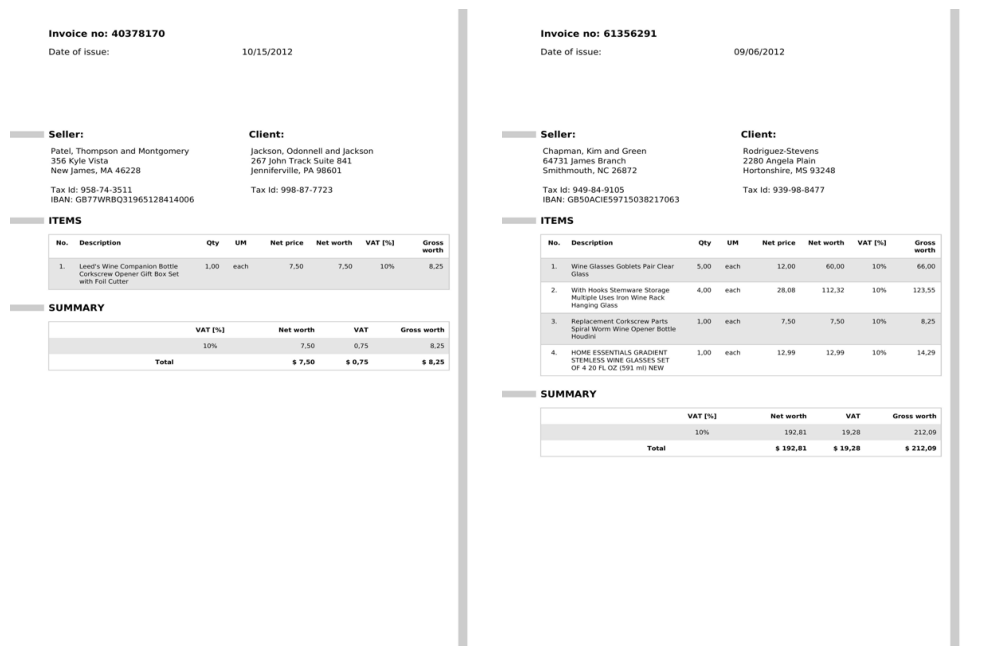

In [28]:
from PIL import Image
import matplotlib.pyplot as plt


def display_images_vertically(image1: Image.Image, image2: Image.Image, figsize=(10, 12)):
    """
    Display two PIL.Image objects separated vertically.

    Args:
        image1: First PIL.Image object
        image2: Second PIL.Image object
        figsize: Tuple specifying figure size (width, height)
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Remove axis ticks and labels
    axes[0].axis("off")
    axes[1].axis("off")

    # Display the images
    axes[0].imshow(image1)
    axes[1].imshow(image2)

    # Add some spacing between images
    plt.subplots_adjust(hspace=0.1)

    plt.tight_layout()
    plt.show()


# Display two images separated vertically using the new function
display_images_vertically(
    dataset["train"][0]["image"].resize((600, 800)), dataset["train"][1]["image"].resize((600, 800))
)

Great, we can see that invoice has the following fields:
- Invoice number
- Date of issue in DD/MM/YYYY format
- Seller
    - Name
    - Address
    - Tax Id
    - IBAN
- Client
    - Name
    - Address
    - Tax Id
- Items
    - Number
    - Description
    - Quantity
    - UM
    - Net price
    - Net worth
    - VAT
    - Gross worth
- Summary
    - Total
    - Currency

For a simple example let's define a simple flat structure, then we will move to a more complex structure that has nested objects

In [29]:
import datetime
from pydantic import BaseModel


class Invoice(BaseModel):
    invoice_number: str
    invoice_date: datetime.datetime
    seller: str
    client: str
    seller_tax_id: str
    client_tax_id: str
    iban: str
    item: str

To pass an image to our VLM model, let's encode it to base64

In [30]:
import base64
from io import BytesIO


# Function to encode the image
def encode_image(image):
    # Convert PIL image to bytes
    buffer = BytesIO()
    image.save(buffer, format="JPEG")  # or format="PNG" if needed
    image_bytes = buffer.getvalue()

    # Encode to base64
    return base64.b64encode(image_bytes).decode("utf-8")


base64_image = encode_image(dataset["train"][0]["image"].resize((600, 800)))

In [31]:
extraction_system_prompt = """You are a helpful assistant for data extraction from invoices. 
You'll be given an invoice and your task is to exract data from it according to the JSON schema."""

extraction_generation_prompt = (
    "Please extract the invoice data from the attached image according to the provided JSON schema."
)

Add the schema to your request (`extra_body.guided_json`)

In [32]:
from openai import OpenAI

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("NEBIUS_API_KEY"),
)

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-VL-72B-Instruct",
    messages=[
        {"role": "system", "content": extraction_system_prompt},
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": extraction_generation_prompt,
                },
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
            ],
        },
    ],
    extra_body={"guided_json": Invoice.model_json_schema()},
)

In [38]:
from pprint import pprint

pprint(parse_completion(completion))

{'client': 'Jackson, Odonnell and Jackson',
 'client_tax_id': '998-87-7723',
 'iban': 'GB77WRBQ31965128414006',
 'invoice_date': '2012-10-15T00:00:00Z',
 'invoice_number': '40378170',
 'item': "Leed's Wine Companion Bottle Corkscrew Opener Gift Box Set with Foil "
         'Cutter',
 'seller': 'Patel, Thompson and Montgomery',
 'seller_tax_id': '958-74-3511'}


Now, let's look at how we can create more complex structures using nested objects. 
As an example, let's describe an item object based on the data we've seen and add it to the Invoice model as a `list[Item]`:

In [ ]:
import datetime
from pydantic import BaseModel


class Item(BaseModel):
    number: int
    description: str
    quantity: int
    unit_of_measure: str
    net_price: float
    net_worth: float
    vat: float
    gross_worth: float


class Invoice(BaseModel):
    invoice_number: str
    invoice_date: datetime.datetime
    seller: str
    client: str
    seller_tax_id: str
    client_tax_id: str
    iban: str
    item: list[Item]

In [42]:
from openai import OpenAI

base64_image = encode_image(dataset["train"][1]["image"].resize((600, 800)))

client = OpenAI(
    base_url="https://api.studio.nebius.com/v1/",
    api_key=os.getenv("NEBIUS_API_KEY"),
)

completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-VL-72B-Instruct",
    messages=[
        {"role": "system", "content": extraction_system_prompt},
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": extraction_generation_prompt,
                },
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}},
            ],
        },
    ],
    extra_body={"guided_json": Invoice.model_json_schema()},
)

pprint(parse_completion(completion))

{'client': 'Rodriguez-Stevens',
 'client_tax_id': '939-98-8477',
 'iban': 'GB50ACIE59715038217063',
 'invoice_date': '0906-06-20T00:00:00Z',
 'invoice_number': '61356291',
 'item': [{'description': 'Wine Glasses Goblets Pair Clear Glass',
           'gross_worth': 66,
           'net_price': 12,
           'net_worth': 60,
           'number': 1,
           'quantity': 5,
           'unit_of_measure': 'each',
           'vat': 10},
          {'description': 'With Hooks Stemware Storage Multiple Uses Iron Wine '
                          'Rack Hanging Glass',
           'gross_worth': 123.55,
           'net_price': 28.08,
           'net_worth': 112.32,
           'number': 2,
           'quantity': 4,
           'unit_of_measure': 'each',
           'vat': 10},
          {'description': 'Replacement Corkscrew Parts Spiral Worm Wine Opener '
                          'Bottle Houdini',
           'gross_worth': 8.25,
           'net_price': 7.5,
           'net_worth': 7.5,
           '

In the code snippet above, the `item` field within the `Invoice` class has been successfully populated with a list of extracted `Item` objects

# Example: RAG Metadata Generation

In this section we will look at another application of **Structured Outputs** in a **Retrieval-Augmented Generation (RAG)** system, 
showcasing how to automatically generate metadata based on a user's query and utilize it to enhance document retrieval precision.
 
We will use the **Haystack** framework for our RAG example due to its simplicity and flexibility. (I really like it, because it allows us to use individual components independently and easily integrate external elements without needing to fully embed our code within their system)

## 1. Import Haystack components

Let's import all needed Haystack components to build our pipeline

In [5]:
from haystack import Pipeline
from haystack.components.embedders import (
    SentenceTransformersDocumentEmbedder,
    SentenceTransformersTextEmbedder,
)
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.dataclasses import Document
from haystack.document_stores.in_memory import InMemoryDocumentStore

/Users/arsenijskunkov/Documents/Code/ai_week_workshop/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Prepare documents

For our application, we will use some synthetic data. Specifically, I used GPT-o3 to scrap different websites (TechCrunch and OpenAI Research Blog) and collect the latest articles in the following format:

```python
Document(
    content="Addendum to OpenAI o3 and o4-mini system card: OpenAI o3 Operator",
    meta={
        "date": "23-05-2025",
        "source": "openai_blog",
        "link": "https://openai.com/index/o3-o4-mini-system-card-addendum-operator-o3",
    },
)
```

The document's content is just the article's title and some metadata, so let's create these document objects.

### TechCrunch Articles

**Notice: The following data is generated via o3 by OpenAI, it can contain hallucinations, but it is not the case for this tutorial.**

In [2]:
documents = [
    # Data for May
    Document(
        content="Google quietly released an app that lets you download and run AI models locally",
        meta={
            "date": "31-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/31/google-quietly-released-an-app-that-lets-you-download-and-run-ai-models-locally/",
        },
    ),
    Document(
        content="Left-leaning influencers embrace Bluesky without abandoning X, Pew says",
        meta={
            "date": "31-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/31/left-leaning-influencers-embrace-bluesky-without-abandoning-x-pew-says/",
        },
    ),
    Document(
        content="NAACP calls on Memphis officials to halt operations at xAI’s ‘dirty data center’",
        meta={
            "date": "31-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/31/naacp-calls-on-officials-to-halt-operations-at-xais-dirty-data-center-in-memphis/",
        },
    ),
    Document(
        content="Report: Elon Musk’s drug use ramped up during the 2024 presidential campaign",
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/report-elon-musks-drug-use-ramped-up-during-the-2024-presidential-campaign/",
        },
    ),
    Document(
        content="It’s not your imagination: AI is speeding up the pace of change",
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/its-not-your-imagination-ai-is-speeding-up-the-pace-of-change/",
        },
    ),
    Document(
        content=(
            "TechCrunch Mobility: A ride-sharing pioneer comes for Uber, "
            "Tesla loses more ground, and dog-like delivery robots land in Texas"
        ),
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/techcrunch-mobility-a-ride-sharing-pioneer-comes-for-uber-tesla-loses-more-ground-and-dog-like-delivery-robots-land-in-texas/",
        },
    ),
    Document(
        content="Trump administration to claw back $3.7B in clean energy and manufacturing awards",
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/trump-administration-to-claw-back-3-7b-in-clean-energy-and-manufacturing-awards/",
        },
    ),
    Document(
        content="Automattic says it will start contributing to WordPress again after pause",
        meta={
            "date": "30-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/30/automattic-says-it-will-start-contributing-to-wordpress-again-after-pause/",
        },
    ),
    Document(
        content="Perplexity’s new tool can generate spreadsheets, dashboards, and more",
        meta={
            "date": "29-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/29/perplexitys-new-tool-can-generate-spreadsheets-dashboards-and-more/",
        },
    ),
    Document(
        content="Delaware attorney general reportedly hires a bank to evaluate OpenAI’s restructuring plan",
        meta={
            "date": "29-05-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/05/29/delaware-attorney-general-reportedly-hires-a-bank-to-evaluate-openais-restructuring-plan/",
        },
    ),
    # Data for April
    Document(
        content="Microsoft’s most capable new Phi 4 AI model rivals the performance of far larger systems",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/",
        },
    ),
    Document(
        content="Sam Altman’s World unveils a mobile verification device",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/sam-altmans-world-unveils-a-mobile-verification-device/",
        },
    ),
    Document(
        content="Epic Games just scored a major win against Apple",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/epic-games-just-scored-a-major-win-against-apple/",
        },
    ),
    Document(
        content="Amazon launches Nova Premier, its most capable AI model yet",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/",
        },
    ),
    Document(
        content="Meta forecasted it would make $1.4 T in revenue from generative AI by 2035",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/meta-forecasted-it-would-make-1-4t-in-revenue-from-generative-ai-by-2035/",
        },
    ),
    Document(
        content="Google’s Gemini chatbot gets upgraded image-creation tools",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/googles-gemini-chatbot-gets-upgraded-image-creation-tools/",
        },
    ),
    Document(
        content="Visa and Mastercard unveil AI-powered shopping",
        meta={
            "date": "30-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/30/visa-and-mastercard-unveil-ai-powered-shopping/",
        },
    ),
    Document(
        content="Musk’s xAI Holdings is reportedly raising the second-largest private funding round ever",
        meta={
            "date": "25-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/25/musks-xai-holdings-is-reportedly-raising-the-second-largest-private-funding-round-ever/",
        },
    ),
    Document(
        content="Noxtua raises $92 M for its sovereign AI tuned for the German legal system",
        meta={
            "date": "22-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/22/noxtua-raises-92m-for-its-sovereign-ai-tuned-for-the-german-legal-system/",
        },
    ),
    Document(
        content="ChatGPT adoption skyrockets in India, but monetization may be trailing",
        meta={
            "date": "04-04-2025",
            "source": "tech_crunch",
            "link": "https://techcrunch.com/2025/04/04/chatgpt-adoption-skyrockets-in-india-but-monetization-may-be-trailing/",
        },
    ),
]

### OpenAI Research Blog

**Notice: The following data is generated via o3 by OpenAI, it can contain hallucinations, but it is not the case for this tutorial.**

In [3]:
documents += [
    Document(
        content="Addendum to OpenAI o3 and o4-mini system card: OpenAI o3 Operator",
        meta={
            "date": "23-05-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/o3-o4-mini-system-card-addendum-operator-o3",
        },
    ),  # :contentReference[oaicite:0]{index=0}
    Document(
        content="Introducing Codex",
        meta={
            "date": "16-05-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/introducing-codex/",
        },
    ),  # :contentReference[oaicite:1]{index=1}
    Document(
        content="Addendum to o3 and o4-mini system card: Codex",
        meta={
            "date": "16-05-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/o3-o4-mini-codex-system-card-addendum/",
        },
    ),  # :contentReference[oaicite:2]{index=2}
    Document(
        content="Introducing HealthBench",
        meta={
            "date": "12-05-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/healthbench/",
        },
    ),  # :contentReference[oaicite:3]{index=3}
    Document(
        content="Thinking with images",
        meta={
            "date": "16-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/thinking-with-images/",
        },
    ),  # :contentReference[oaicite:4]{index=4}
    Document(
        content="OpenAI o3 and o4-mini System Card",
        meta={
            "date": "16-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/o3-o4-mini-system-card/",
        },
    ),  # :contentReference[oaicite:5]{index=5}
    Document(
        content="Introducing OpenAI o3 and o4-mini",
        meta={
            "date": "16-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/introducing-o3-and-o4-mini/",
        },
    ),  # :contentReference[oaicite:6]{index=6}
    Document(
        content="Our updated Preparedness Framework",
        meta={
            "date": "15-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/updating-our-preparedness-framework/",
        },
    ),  # :contentReference[oaicite:7]{index=7}
    Document(
        content="Introducing GPT-4.1 in the API",
        meta={
            "date": "14-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/gpt-4-1/",
        },
    ),  # :contentReference[oaicite:8]{index=8}
    Document(
        content="BrowseComp: a benchmark for browsing agents",
        meta={
            "date": "10-04-2025",
            "source": "openai_blog",
            "link": "https://openai.com/index/browsecomp/",
        },
    ),  # :contentReference[oaicite:9]{index=9}
]

## 3. Creating InMemoryDocumentStore

Now, we will set up a document indexing pipeline using an in-memory document store and a sentence transformer embedder.
It embeds documents into vector representations and writes them to the store, enabling efficient similarity search.
The pipeline is then run to process and store the provided documents.

In [4]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(
    "embedder",
    SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"),
)
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
indexing_pipeline.connect("embedder", "writer")

# Run the indexing pipeline
indexing_pipeline.run({"embedder": {"documents": documents}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]/Users/arsenijskunkov/Documents/Code/ai_week_workshop/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


{'writer': {'documents_written': 30}}

## 4. Define QueryMetadata Structure 

Now, let's define a `QueryMetadata` object using Pydantic.
Note that each `Field` can have a default value and a description.

Additionally, we can restrict values by providing a finite list of acceptable values for each field. Since we have only two values for the `source` field in the metadata, we will guide the model to generate tokens only from this set of values.

In [5]:
from typing import Literal
from pydantic import Field, BaseModel


class QueryMetadata(BaseModel):
    start_date: str = Field(
        None,
        description=(
            "The start date of a potential time range, extracted from the user's query. The format should be DD-MM-YYYY."
        ),
    )
    end_date: str = Field(
        description=(
            "The end date of a potential time range, extracted from the user's query. The format should be DD-MM-YYYY."
        ),
    )
    source: Literal["tech_crunch", "openai_blog"]

In [6]:
metadata_system_prompt = """
You are an information extraction system that analyzes natural language queries and extracts metadata in a specific JSON format.

Your task is to extract the following metadata fields:
- start_date: string in "DD-MM-YYYY" format (e.g., "01-01-2024")
- end_date: string in "DD-MM-YYYY" format (e.g., "31-12-2024")
- source: one of ["tech_crunch", "openai_blog"]

Rules:
- If a field is not present in the query, set its value to null.
- Use only the allowed values for 'source'.
- Always return only a valid JSON object. Do not include any explanation or extra text.
"""

metadata_generation_prompt = "User Query: {query}\n\nExtract the metadata as specified."

In [33]:
def generate_query_metadata(query: str) -> dict[str, any]:
    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-72B-Instruct",
        messages=[
            {"role": "system", "content": metadata_system_prompt},
            {
                "role": "user",
                "content": metadata_generation_prompt.format(query=query),
            },
        ],
        temperature=0.0,
        extra_body={"guided_json": QueryMetadata.model_json_schema()},
    )

    parsed_metadata = parse_completion(completion)

    return parsed_metadata

In [34]:
query = "Find me top 3 TechCrunch articles from April 2025"

print(metadata_generation_prompt.format(query=query) + "\n")
print(generate_query_metadata(query))

User Query: Find me top 3 TechCrunch articles from April 2025

Extract the metadata as specified.

{'start_date': '01-04-2025', 'end_date': '30-04-2025', 'source': 'tech_crunch'}


## 5. Define the RAG Pipeline with Structured Output
This is where we'll build the main pipeline that uses the LLM to generate
structured metadata from the user's query and then uses that metadata to
filter the documents during the search operation.

The prompt template instructs the LLM to extract the metadata and provides
the JSON schema for the output. This is crucial for getting the structured output.

### Prepare filters

In [35]:
def prepare_filters(extracted_metadata: dict[str, any]):
    filters = {}
    conditions = []

    if extracted_metadata["source"]:
        conditions.append(
            {
                "field": "source",
                "operator": "==",
                "value": extracted_metadata["source"],
            }
        )

    if extracted_metadata["start_date"] and extracted_metadata["end_date"]:
        conditions.append(
            {
                "field": "date",
                "operator": ">=",
                "value": extracted_metadata["start_date"],
            }
        )
        conditions.append(
            {
                "field": "date",
                "operator": "<=",
                "value": extracted_metadata["end_date"],
            }
        )
    elif extracted_metadata["start_date"]:
        conditions.append(
            {
                "field": "date",
                "operator": ">=",
                "value": extracted_metadata["start_date"],
            }
        )
    elif extracted_metadata["end_date"]:
        conditions.append(
            {
                "field": "date",
                "operator": "<=",
                "value": extracted_metadata["end_date"],
            }
        )

    if conditions:
        filters = {"operator": "AND", "conditions": conditions}

    return filters

### Pipeline

In [36]:
def run_query(query: str):
    """
    This function runs the RAG pipeline for a given query.
    It first generates the structured metadata and then uses it to retrieve documents.
    """
    print(f"Running query: '{query}'")

    extracted_metadata = generate_query_metadata(query)

    print("[1] Extracted Metadata:\n")
    print(extracted_metadata)

    print("2] Prepare Filters and Run Query:\n")
    filters = prepare_filters(extracted_metadata=extracted_metadata)

    text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
    retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k=3, filters=filters)

    retrieval_pipeline = Pipeline()
    retrieval_pipeline.add_component("text_embedder", text_embedder)
    retrieval_pipeline.add_component("retriever", retriever)
    retrieval_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

    retrieval_result = retrieval_pipeline.run({"text_embedder": {"text": query}})

    print("\n[3] Retrieved Documents:")
    for doc in retrieval_result["retriever"]["documents"]:
        print(f"  - {doc.content} (Source: {doc.meta['source']}, " f"Date: {doc.meta['date']})")

In [37]:
query = "Find me 3 oldest TechCrunch articles from April 2025"

run_query(query)

Running query: 'Find me 3 oldest TechCrunch articles from April 2025'
[1] Extracted Metadata:

{'start_date': '01-04-2025', 'end_date': '30-04-2025', 'source': 'tech_crunch'}
2] Prepare Filters and Run Query:



Batches:   0%|          | 0/1 [00:00<?, ?it/s]/Users/arsenijskunkov/Documents/Code/ai_week_workshop/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


[3] Retrieved Documents:
  - Meta forecasted it would make $1.4 T in revenue from generative AI by 2035 (Source: tech_crunch, Date: 30-04-2025)
  - Microsoft’s most capable new Phi 4 AI model rivals the performance of far larger systems (Source: tech_crunch, Date: 30-04-2025)
  - Amazon launches Nova Premier, its most capable AI model yet (Source: tech_crunch, Date: 30-04-2025)


# Example: Structured Outputs & Custom CoT

Finally, one of the best patterns I've seen and use quite often in my projects is **Chain Of Thought combined with Structured Outputs**. I learned about this pattern in a course by Rinat Abdullin (you can read his blog post about [Schema Guided Reasoning](https://abdullin.com/schema-guided-reasoning)). This approach leverages the Chain of Thought paradigm to guide the LLM’s reasoning along a predefined path, using Structured Outputs to enforce consistency and direction.

Some benefits we get using this pattern are:
1. Enhanced ability to trace, debug, and audit reasoning chains, providing greater transparency of the LLM's intermediate outputs.
2. The capability to convert domain expertise into executable prompts.
3. Improved reasoning capabilities for smaller and less advanced models.

Let's see how it works with a simple example. We will use this approach to guide the model towards solving a simple equation.
Each reasoning step will have an output and an explanation, and we will combine them into a list of steps that the LLM will use to generate reasoning about the problem:

In [7]:
class Step(BaseModel):
    explanation: str
    output: str


class MathReasoning(BaseModel):
    steps: list[Step]
    final_answer: str

In [8]:
completion = client.chat.completions.create(
    model="Qwen/Qwen2.5-72B-Instruct",
    messages=[
        {
            "role": "user",
            "content": "Solve the equation 8x + 7 = -23",
        },
    ],
    extra_body={"guided_json": MathReasoning.model_json_schema()},
)

answer = parse_completion(completion)

When we print the output, we will be able to see how the model was thinking in a predefined way before generating an answer.

In [9]:
from pprint import pprint

pprint(answer)

{'final_answer': 'The solution to the equation 8x + 7 = -23 is x = -3.75.',
 'steps': [{'explanation': 'To solve the equation, we first aim to isolate the '
                           'variable x on one side of the equation. We can do '
                           'this by performing the same operations on both '
                           'sides of the equation to maintain equality.',
            'output': 'Given the equation 8x + 7 = -23.'},
           {'explanation': 'Subtract 7 from both sides of the equation to move '
                           'the constant term to the right side.',
            'output': '8x + 7 - 7 = -23 - 7'},
           {'explanation': 'Simplify the left and right sides.',
            'output': '8x = -30'},
           {'explanation': 'Divide both sides by 8 to isolate x.',
            'output': '8x / 8 = -30 / 8'},
           {'explanation': 'Simplify to find the value of x.',
            'output': 'x = -3.75'}]}


Now, I want to show a more complex example inspired by a winning solution from the [RAG Enterprise Challenge](https://abdullin.com/ilya/how-to-build-best-rag/).
 
We can apply the SO & CoT pattern to answer questions based on complex documents using intermediate reasoning.
We will take the [How much do language models memorize?](https://arxiv.org/abs/2505.24832) article from arXiv as the document the LLM will answer about.

We will first ask the LLM to fill the `step_by_step_analysis` field, then proceed to a reasoning summary and generate the final answer:

In [6]:
from pydantic import Field, BaseModel
from typing import List


class AnswerSchema(BaseModel):
    step_by_step_analysis: str = Field(
        description="Detailed step-by-step analysis of the answer with at least 5 steps and at least 150 words. Always do this step exactly as prompted."
    )

    reasoning_summary: str = Field(
        description="Concise summary of the step-by-step reasoning process. Around 50 words."
    )

    relevant_chunks: List[int] = Field(
        description="""
            List of page chunks containing information directly used to answer the question. Include only:
            - Chunk with direct answers or explicit statements
            - Chunks with key information that strongly supports the answer
            Do not include chunks with only tangentially related information or weak connections to the answer.
            At least one chunk should be included in the list.
        """
    )

    final_answer: str

Now we will split this long article into chunks and load into the vector database

In [7]:
from pathlib import Path
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()

pipeline = Pipeline()
pipeline.add_component("converter", HTMLToDocument())
pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=3))
pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
pipeline.add_component("writer", DocumentWriter(document_store=document_store))
pipeline.connect("converter", "splitter")
pipeline.connect("splitter", "embedder")
pipeline.connect("embedder", "writer")

pipeline.run({"converter": {"sources": [Path("./data/How much do language models memorize?.html")]}})

No abbreviations file found for en. Using default abbreviations.
Batches:   0%|          | 0/3 [00:00<?, ?it/s]/Users/arsenijskunkov/Documents/Code/ai_week_workshop/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


{'writer': {'documents_written': 71}}

In [8]:
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k=10)

retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("text_embedder", text_embedder)
retrieval_pipeline.add_component("retriever", retriever)
retrieval_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])

Now, we will retrieve chunks relevant to the query

In [9]:
query = """
How do models define, measure, and differentiate between intended and unintended memorisation?
"""

retrieval_result = retrieval_pipeline.run({"text_embedder": {"text": query}})

Batches: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


In [20]:
strs = ""

for doc in retrieval_result["retriever"]["documents"]:
    strs += f"Chunk: {doc.meta['split_id']}, Content:\n{doc.content}\n\n"

In [21]:
for i in range(3):
    print(strs.split("\n\n")[i] + "\n")

Chunk: 27, Content:
Hence, we can define unintended memorization as
and then the generalization (or intended memorization) must be
Now that we have defined our notions of intended and unintended memorization we turn our attention to practically measuring them. Let us first state a proposition that enables measurement of unintended memorization:
Proposition 1 (Super-additivity of Unintended Memorization).
Assume is a dataset of i.i.d. 

Chunk: 26, Content:
To understand how much information about is stored in , we can use the notion of mutual information:
Note that this captures all the information about that is stored in . As we discussed, we need our notion of memorization to account for generalization as well. So when measuring unintended memorization, we are only interested in the information that is present in , which is the uncertainty left in after fixing . 

Chunk: 18, Content:
Our notion of unintended memorization must be distinct from intended memorization, which we refer to a

And now we will combine our query with the extracted chunks to synthesize the answer that will be guided by our JSON scheme

In [25]:
def generate_answer(query: str, context: str) -> dict[str, any]:
    completion = client.chat.completions.create(
        model="google/gemma-3-27b-it",
        messages=[
            {
                "role": "user",
                "content": f"Answer this question {query} based on these data points: {context}. Think before you answer.",
            },
        ],
        temperature=0.0,
        extra_body={"guided_json": AnswerSchema.model_json_schema()},
    )

    parsed_answer = parse_completion(completion)

    return parsed_answer

In [26]:
query = """
How do models define, measure, and differentiate between intended and unintended memorisation?
"""

parsed_answer = generate_answer(query, strs)

Finally, let's look at the reasoning steps and other fields from the final response

In [27]:
parsed_answer

{'step_by_step_analysis': "Here's a breakdown of how the provided text defines, measures, and differentiates between intended and unintended memorization in language models:\n\n**1. Definitions:**\n\n*   **Unintended Memorization:** This is defined as the information a model contains *about a specific dataset* it was trained on. It's essentially rote learning – the model has 'memorized' the training data itself.\n*   **Intended Memorization (Generalization):** This is defined as the information a model contains about the *true data-generation process*.  This is what we *want* the model to learn – the underlying patterns and relationships in the data, allowing it to perform well on unseen data.\n\n**2. Measurement:**\n\n*   **Mutual Information:** The text introduces mutual information as a way to understand how much information about a dataset (x) is stored in a model (y). However, it clarifies that for *unintended* memorization, they are only interested in the information present in y

In [28]:
from pprint import pprint

pprint(parsed_answer, indent=4)

{   'final_answer': 'The models define unintended memorization as the '
                    'information a model contains about a specific dataset, '
                    'while intended memorization (generalization) is the '
                    'information about the true data-generation process. They '
                    'aim to measure unintended memorization using mutual '
                    'information, focusing on the information remaining in the '
                    'model after accounting for the training data, and a '
                    "proposition about 'super-additivity'. Differentiation is "
                    'achieved by separating rote learning of the training data '
                    'from learning underlying patterns.',
    'reasoning_summary': 'The text defines unintended memorization as '
                         'information about a specific dataset and intended '
                         'memorization (generalization) as information about '
                